In [1]:
from collections import defaultdict, Counter
import numpy as np
from json import load, dump
import os

## Lade Wörter und finde Wörter, die weniger als drei mal vorkommen sowie kleiner als drei Zeichen lang sind

In [3]:
words = Counter()
words_in_month = Counter()
i = 0
files = []
months = {}

for file in os.listdir("./Months_Filtered/"):
    if file.endswith(".json"):
        files.append(file)
        with open(f"./Months_Filtered/{file}", 'r', encoding="utf-8") as f:
            tokens = [t.strip('.') for t in load(f)]
            months[file] = tokens
            words.update(tokens)
            words_in_month.update(set(tokens))
            i +=1
            

In [4]:
print(f"Anzahl Tokens pro Monat: {sum(words.values())/i}")
print(f"Anzahl unique Tokens pro Monat: {sum(words_in_month.values())/i}")
print(f"Gesamt-Anzahl Token-Erwähnungen: {sum(words.values())}")
print(f"Gesamt-Anzahl unique Tokens: {len(words)}")

Anzahl Tokens pro Monat: 17276.654761904763
Anzahl unique Tokens pro Monat: 6281.535714285715
Gesamt-Anzahl Token-Erwähnungen: 1451239
Gesamt-Anzahl unique Tokens: 100364


In [5]:
small_words = {word:words[word] for word in words if len(word)<3}
len(small_words)

206

In [6]:
valid_small_words = ('xi','un','eu','de','is','wm','em')

In [7]:
small_occurrences = {word:words[word] for word in words if words[word]<3}
len(small_occurrences)

65361

# Bereinigung des Corpus
* tokens, die weniger Buchstaben haben als 3 und/oder weniger oft als dreimal vorkommen
* speichern für die spätere Berechnung der Tf-idf

In [8]:
def filter_corpus(l):
    return [w for w in l if w not in small_occurrences and not (w in small_words and w not in valid_small_words)]

In [9]:
files = sorted(sorted(files), key=lambda x: x[3:7])
corpus = []
sums = []
for file in files:
    '''
    with open(f"./Months_Filtered/{file}", 'r', encoding="utf-8") as f:
        month = Counter(filter_corpus(load(f)))
        corpus.append(month)
        sums.append(sum(month.values()))
    '''
    month_corpus = filter_corpus(months[file])
    # save
    with open(f"./Months_Cleaned/{file}", 'w', encoding="utf-8") as f:
        dump(month_corpus, f)
    month = Counter(month_corpus)
    corpus.append(month)
    sums.append(sum(month.values()))

In [10]:
len(corpus), len(sums)

(84, 84)

In [16]:
np.mean([sum(x.values()) for x in corpus])

16269.404761904761

In [17]:
np.mean([len(x) for x in corpus])

5352.428571428572

## Baue Tabelle mit Wortdichten

In [11]:
matrix = defaultdict(list)
for i, word in enumerate(words):
    if word in small_occurrences: continue
    if word in small_words and word not in valid_small_words: continue
    for month,sum_  in zip(corpus,sums):
        count = month[word]
        if not count: matrix[word].append(0.0)
        else: matrix[word].append(count/sum_*1000)
    if not i%1000: print(f"{i} words proccessed")

0 words proccessed
1000 words proccessed
2000 words proccessed
3000 words proccessed
4000 words proccessed
5000 words proccessed
6000 words proccessed
7000 words proccessed
9000 words proccessed
10000 words proccessed
11000 words proccessed
12000 words proccessed
14000 words proccessed
15000 words proccessed
16000 words proccessed
17000 words proccessed
19000 words proccessed
21000 words proccessed
22000 words proccessed
24000 words proccessed
35000 words proccessed
40000 words proccessed
41000 words proccessed
43000 words proccessed
46000 words proccessed
47000 words proccessed
54000 words proccessed
55000 words proccessed
56000 words proccessed
60000 words proccessed
69000 words proccessed
77000 words proccessed
85000 words proccessed
87000 words proccessed
90000 words proccessed


In [12]:
len(matrix)

34863

## Ordne Tabelle absteigend nach Wortdichten

In [13]:
matrix = {k:matrix[k] for k in sorted(matrix, key=lambda x: sum(matrix[x]), reverse=True)}

In [14]:
set(len(v) for v in matrix.values())

{84}

## Speichere Tabelle als JSON für Website

In [17]:
with open("./table.json", 'w') as f:
    dump(matrix, f)

In [15]:
list(matrix.keys())[:30]

['mensch',
 'land',
 'deutsch',
 'deutschland',
 'neu',
 'regierung',
 'präsident',
 'regen',
 'flüchtling',
 'trump',
 'woche',
 'wolke',
 'usa',
 'euro',
 'eu',
 'schauer',
 'anderer',
 'merkel',
 'spd',
 'süden',
 'russland',
 'norden',
 'europa',
 'nacht',
 'berlin',
 'sonne',
 'partei',
 'polizei',
 'letzter',
 'stark']

In [20]:
krise = matrix['krise']
for term, values in matrix.items():
    if 'krise' in term:
        for value,goal in zip(values,krise):
            if value > goal:
                print(term)
                break

corona-krise
flüchtlingskrise
wirtschaftskrise
schuldenkrise
regierungskrise


## Visualisierung für die Präsentation

In [34]:
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [35]:
fontsize = 26
plt.rcParams["font.family"] = 'PT Sans','Noto Sans', 'Noto Serif'
plt.rcParams["xtick.labelsize"] = fontsize*0.8
plt.rcParams["ytick.labelsize"] = fontsize
plt.rcParams["legend.fontsize"] = fontsize
plt.rcParams["ytick.major.pad"] = 10
plt.rcParams["xtick.major.pad"] = 10

In [17]:
def get_dateStrings():
    result = []
    mon, year = 6,2014
    for i in range(len(corpus)):
        if mon>12:
            mon=1
            year+=1
        result.append(datetime.date(year, mon, 1).strftime("%b\n%Y")) #
        mon+=1
    return result
datestrings = get_dateStrings()

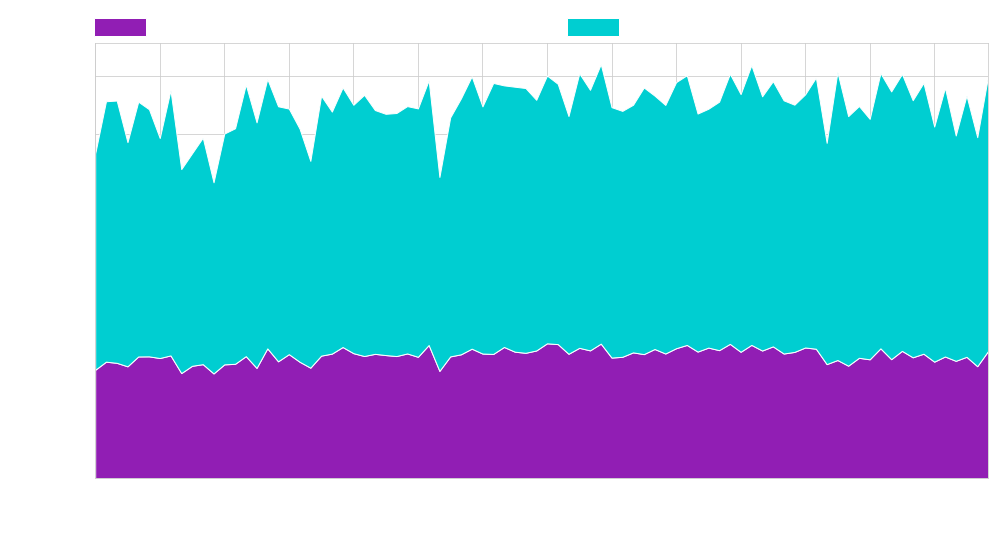

In [18]:
fig, ax = plt.subplots(figsize=(16,8))
unique_words = [len(words) for words in corpus]
sum_words = [s-uniques for s,uniques in zip(sums,unique_words)]
ax.stackplot(datestrings, (unique_words, sum_words), colors=('#911eb4','#00ced1'), labels=('Anzahl einzigartiger Begriffe','Anzahl Mehrfachnennungen'))
plt.xticks(ticks=[datestrings[i] for i in range(len(datestrings)) if not i%6],  color='white') # ,rotation=-45, ha='left'
plt.yticks(color='white')
ax.set_xlim(left=datestrings[0], right=datestrings[-1])

ax.legend(ncol=2, bbox_to_anchor=(-0.028, 1.115), frameon=False, loc='upper left', labelcolor='white')

#ax.bar(datestrings, unique_words, width=1)
#ax.bar(datestrings, , bottom=unique_words, width=1)

plt.savefig("Wörter_pro_Monat.png",dpi=600, bbox_inches='tight', transparent=True)
plt.show()

## Gefundene Wörter pro Minute Sendungszeit

In [26]:
sum(sums)/2408/15

37.835825027685495